# Scikit-Learn ML Model Explainability

[SHAP (SHapley Additive exPlanations)](https://github.com/shap/shap) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

In [1]:
import boto3
from datetime import date
import lightgbm as lgb
import math
import matplotlib.pyplot as plt
import numpy as pd
import pandas as pd
import seaborn as sns
import shap

from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Dataset

* [Kaggle](https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists)

In [25]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

df = pd.concat([df_train, df_test])
df.shape

(21287, 14)

In [3]:
df.head().transpose()

,0,1,2,3,4
enrollee_id,8949,29725,11561,33241,666
city,city_103,city_40,city_21,city_115,city_162
city_development_index,0.92,0.776,0.624,0.789,0.767
gender,Male,Male,NaN,NaN,Male
relevent_experience,Has relevent experience,No relevent experience,No relevent experience,No relevent experience,Has relevent experience
enrolled_university,no_enrollment,no_enrollment,Full time course,NaN,no_enrollment
education_level,Graduate,Graduate,Graduate,Graduate,Masters
major_discipline,STEM,STEM,STEM,Business Degree,STEM
experience,>20,15,5,<1,>20
company_size,NaN,50-99,NaN,NaN,50-99


## Preprocessing

In [26]:
# can ID be used as unique identifier?
df['enrollee_id'].nunique() == df.shape[0]
# there are as many IDs as there are rows in the dataset

True

In [27]:
df['duplicated'] = df.drop(columns=['enrollee_id']).duplicated()

In [28]:
df['duplicated'].value_counts()
# there are 50 ids that are dups

False    21237
True        50
Name: duplicated, dtype: int64

In [29]:
# drop all lines that are duplicated entries
df.drop(df[df['duplicated'] == True].index, inplace = True)
df['duplicated'].value_counts()

False    21235
Name: duplicated, dtype: int64

In [30]:
for col in df.columns:
    print(f' \n {col.upper()} :: {df[col].nunique()} UNIQUE :: {df[col].isnull().sum()} NULL')

 
 ENROLLEE_ID :: 21235 UNIQUE :: 0 NULL
 
 CITY :: 123 UNIQUE :: 0 NULL
 
 CITY_DEVELOPMENT_INDEX :: 93 UNIQUE :: 0 NULL
 
 GENDER :: 3 UNIQUE :: 5015 NULL
 
 RELEVENT_EXPERIENCE :: 2 UNIQUE :: 0 NULL
 
 ENROLLED_UNIVERSITY :: 3 UNIQUE :: 417 NULL
 
 EDUCATION_LEVEL :: 5 UNIQUE :: 512 NULL
 
 MAJOR_DISCIPLINE :: 6 UNIQUE :: 3121 NULL
 
 EXPERIENCE :: 22 UNIQUE :: 70 NULL
 
 COMPANY_SIZE :: 8 UNIQUE :: 6541 NULL
 
 COMPANY_TYPE :: 6 UNIQUE :: 6755 NULL
 
 LAST_NEW_JOB :: 6 UNIQUE :: 463 NULL
 
 TRAINING_HOURS :: 241 UNIQUE :: 0 NULL
 
 TARGET :: 2 UNIQUE :: 2127 NULL
 
 DUPLICATED :: 1 UNIQUE :: 0 NULL


In [31]:
# remove all entires that don't have the target value
df.dropna(subset=['target'], how='all', inplace=True)
df['target'].value_counts()
# we need a model that can handle imbalanced datasets -> gradient boosted decision trees (lightgbm)

0.0    14343
1.0     4765
Name: target, dtype: int64

In [32]:
df['company_size'].value_counts()

50-99        3080
100-500      2560
10000+       2009
10/49        1470
1000-4999    1322
<10          1308
500-999       877
5000-9999     562
Name: company_size, dtype: int64

In [33]:
df['company_size'] = df['company_size'].apply(lambda x: '10-49' if x == '10/49' else x)
df['company_size'].value_counts()

50-99        3080
100-500      2560
10000+       2009
10-49        1470
1000-4999    1322
<10          1308
500-999       877
5000-9999     562
Name: company_size, dtype: int64

<Axes: >

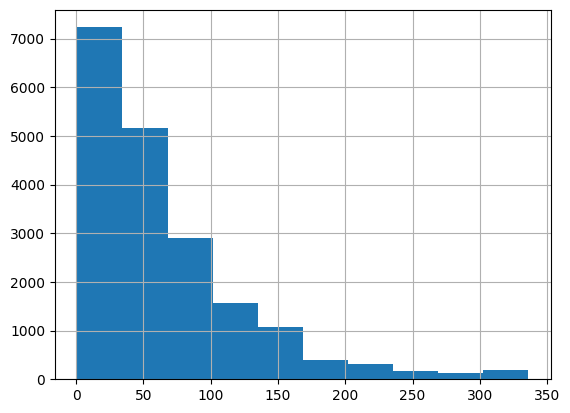

In [34]:
df['training_hours'].hist()

<Axes: xlabel='education_level', ylabel='training_hours'>

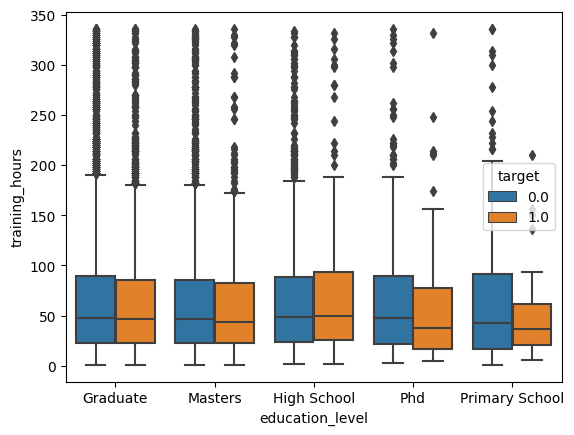

In [35]:
sns.boxplot(data=df, x='education_level', y='training_hours', hue='target')

In [36]:
# drop columns that will not have an influence on the target variable
df_train = df.drop(['duplicated', 'enrollee_id'], axis=1)

In [37]:
# make target variable int
df_train['target'] = pd.to_numeric(df_train['target'])
df_train['target'] = df_train['target'].astype(int)

## Data Transformation

In [38]:
# encode categorical columns
categorical_columns = []

for col in df_train.columns:
    print('\n')
    print(f'INFO :: Column {col} is of type {df_train[col].dtype} .')
    if df_train[col].dtype == 'object':
        print('PROCESSING :: Added for dummy variable creation.')
        categorical_columns.append(col)

df_train = pd.get_dummies(df_train, columns=categorical_columns)



INFO :: Column city is of type object .
PROCESSING :: Added for dummy variable creation.


INFO :: Column city_development_index is of type float64 .


INFO :: Column gender is of type object .
PROCESSING :: Added for dummy variable creation.


INFO :: Column relevent_experience is of type object .
PROCESSING :: Added for dummy variable creation.


INFO :: Column enrolled_university is of type object .
PROCESSING :: Added for dummy variable creation.


INFO :: Column education_level is of type object .
PROCESSING :: Added for dummy variable creation.


INFO :: Column major_discipline is of type object .
PROCESSING :: Added for dummy variable creation.


INFO :: Column experience is of type object .
PROCESSING :: Added for dummy variable creation.


INFO :: Column company_size is of type object .
PROCESSING :: Added for dummy variable creation.


INFO :: Column company_type is of type object .
PROCESSING :: Added for dummy variable creation.


INFO :: Column last_new_job is of type ob

In [17]:
df_train.head(5).transpose()

,0,1,2,3,4
city_development_index,0.92,0.776,0.624,0.789,0.767
training_hours,36.00,47.000,83.000,52.000,8.000
target,1.00,0.000,0.000,1.000,0.000
city_city_1,0.00,0.000,0.000,0.000,0.000
city_city_10,0.00,0.000,0.000,0.000,0.000
...,...,...,...,...,...
last_new_job_2,0.00,0.000,0.000,0.000,0.000
last_new_job_3,0.00,0.000,0.000,0.000,0.000
last_new_job_4,0.00,0.000,0.000,0.000,1.000
last_new_job_>4,0.00,1.000,0.000,0.000,0.000


In [39]:
# correlation matrix
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df_train.corr().transpose()

,city_development_index,training_hours,target,city_city_1,city_city_10,city_city_100,city_city_101,city_city_102,city_city_103,city_city_104,city_city_105,city_city_106,city_city_107,city_city_109,city_city_11,city_city_111,city_city_114,city_city_115,city_city_116,city_city_117,city_city_118,city_city_12,city_city_120,city_city_121,city_city_123,city_city_126,city_city_127,city_city_128,city_city_129,city_city_13,city_city_131,city_city_133,city_city_134,city_city_136,city_city_138,city_city_139,city_city_14,city_city_140,city_city_141,city_city_142,city_city_143,city_city_144,city_city_145,city_city_146,city_city_149,city_city_150,city_city_152,city_city_155,city_city_157,city_city_158,city_city_159,city_city_16,city_city_160,city_city_162,city_city_165,city_city_166,city_city_167,city_city_171,city_city_173,city_city_175,city_city_176,city_city_179,city_city_18,city_city_180,city_city_19,city_city_2,city_city_20,city_city_21,city_city_23,city_city_24,city_city_25,city_city_26,city_city_27,city_city_28,city_city_30,city_city_31,city_city_33,city_city_36,city_city_37,city_city_39,city_city_40,city_city_41,city_city_42,city_city_43,city_city_44,city_city_45,city_city_46,city_city_48,city_city_50,city_city_53,city_city_54,city_city_55,city_city_57,city_city_59,city_city_61,city_city_62,city_city_64,city_city_65,city_city_67,city_city_69,city_city_7,city_city_70,city_city_71,city_city_72,city_city_73,city_city_74,city_city_75,city_city_76,city_city_77,city_city_78,city_city_79,city_city_8,city_city_80,city_city_81,city_city_82,city_city_83,city_city_84,city_city_89,city_city_9,city_city_90,city_city_91,city_city_93,city_city_94,city_city_97,city_city_98,city_city_99,gender_Female,gender_Male,gender_Other,relevent_experience_Has relevent experience,relevent_experience_No relevent experience,enrolled_university_Full time course,enrolled_university_Part time course,enrolled_university_no_enrollment,education_level_Graduate,education_level_High School,education_level_Masters,education_level_Phd,education_level_Primary School,major_discipline_Arts,major_discipline_Business Degree,major_discipline_Humanities,major_discipline_No Major,major_discipline_Other,major_discipline_STEM,experience_1,experience_10,experience_11,experience_12,experience_13,experience_14,experience_15,experience_16,experience_17,experience_18,experience_19,experience_2,experience_20,experience_3,experience_4,experience_5,experience_6,experience_7,experience_8,experience_9,experience_<1,experience_>20,company_size_10-49,company_size_100-500,company_size_1000-4999,company_size_10000+,company_size_50-99,company_size_500-999,company_size_5000-9999,company_size_<10,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never
city_development_index,1.000000,0.002262,-0.341331,0.005476,0.036130,0.057098,-0.137703,-0.025443,0.399749,0.097710,-0.018115,-0.022991,-0.044623,-0.022463,-0.258452,-0.013272,0.216207,-0.017124,-0.057028,-0.027634,-0.032524,-0.039898,-0.006993,-0.004843,-0.047355,-0.108559,-0.015520,-0.170054,-0.020685,-0.000688,-0.026157,-0.016076,-0.050299,0.098460,0.004708,-0.044798,-0.040572,0.001601,-0.020026,-0.043462,-0.033329,0.003573,-0.127565,-0.015539,-0.082931,-0.061877,-0.054790,-0.059838,-0.016423,-0.025760,0.008109,0.194393,0.158865,-0.041056,0.039533,-0.021071,0.017117,-0.009655,0.035662,-0.011563,-0.018591,-0.041520,-0.000550,-0.020275,-0.094106,-0.006313,-0.010329,-0.672456,0.055872,-0.060427,-0.015325,-0.037559,0.007769,0.090060,-0.035130,-0.002544,-0.092061,0.047888,-0.007613,0.013480,-0.025519,-0.000938,-5.617980e-02,-0.063522,-0.025803,0.038320,-0.044384,-0.070981,0.046860,-0.026531,0.005992,-0.019682,0.022257,-0.009957,0.069732,-0.024083,-0.102141,-0.020796,3.238568e-02,0.006604,-0.055387,-0.050881,0.053254,-0.008838,-0.073815,-0.149689,0.113849,-0.054248,0.000434,

In [ ]:
#plotting the heatmap for correlation
plt.figure(figsize=(128, 128), dpi=200)

sns.heatmap(df_train.corr(numeric_only=True),
    linewidth=0.5,
    cmap='seismic',
    annot=False)

plt.savefig('assets/Correlation_Heatmap.png', bbox_inches='tight')

![Scikit-Learn ML Model Explainability](./assets/Correlation_Heatmap.avif)

In [45]:
# correlation to target
def gen_correlation_df(dataframe, target):
    correlations = {
        'variable': [],
        'corr': []
    }
    
    for col in list(dataframe.columns):
        if dataframe[col].dtype not in ['object', '<M8[ns]'] and col !=  target:
            r = dataframe[target].corr(dataframe[col])
            correlations['variable'].append(col)
            correlations['corr'].append(r)
            
    return pd.DataFrame(correlations).sort_values(by=['corr'], ascending = False)

In [47]:
df_cor = gen_correlation_df(df_train, 'target')
df_cor

,variable,corr
66,city_city_21,0.319434
130,enrolled_university_Full time course,0.149529
129,relevent_experience_No relevent experience,0.127994
13,city_city_11,0.091457
133,education_level_Graduate,0.087214
164,experience_<1,0.079047
144,experience_1,0.069583
157,experience_3,0.066304
26,city_city_128,0.050778
143,major_discipline_STEM,0.050013


## Model Training

In [48]:
# train-test split
train, test = train_test_split(df_train, test_size=0.2)

In [49]:
# remove target label from training dataset
X_cols = list(set(train.columns) - set(['target']))

In [53]:
def split_xy(train_in, test_in, X_cols, target):
    train = train_in.copy()
    test = test_in.copy()

    X_train = train[X_cols].copy()
    X_test = test[X_cols].copy()

    y_train = train[target]
    y_test = test[target]

    return X_train, X_test, y_train, y_test

In [54]:
X_train, X_test, y_train, y_test = split_xy(test, train, X_cols, 'target')

In [60]:
# verify 80/20 train-test split
print(X_test.shape[0] / (X_train.shape[0] + X_test.shape[0]) * 100)

79.99790663596399


### Grid Search

In [62]:
# create shuffled splits
cv_split = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=77)

In [63]:
# create search params
param_grid = {
    'learning_rate': [0.05],
    'n_estimators': [400],
    'max_depth': [5, 7],
    'min_child_samples': [50, 200, 600],
    'num_leaves': [31, 63]
}

In [64]:
def fit_lgb(param_grid, X, y, cv):
    gbm = lgb.LGBMClassifier(
        objective='binary',
        feature_fraction=0.9
    )

    grid_search = GridSearchCV(
        gbm,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=cv,
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(X=X, y=y.values.ravel())

    print(grid_search.best_score_)
    print(grid_search.best_estimator_)
    print(grid_search.best_params_)

    return grid_search

In [ ]:
grid_search = fit_lgb(param_grid, X_train, y_train, cv_split)

# 0.8067351303514142
# LGBMClassifier(feature_fraction=0.9, learning_rate=0.05, max_depth=5,
#                min_child_samples=50, n_estimators=400, objective='binary')
# {'learning_rate': 0.05, 'max_depth': 5, 'min_child_samples': 50, 'n_estimators': 400, 'num_leaves': 31}

## Model Evaluation

In [69]:
# pass test data to trained model
y_pred = grid_search.best_estimator_.predict_proba(X_test)[:,1]

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [70]:
auc = metrics.roc_auc_score(y_true=y_test, y_score=y_pred)
auc

0.7834230893204323

In [77]:
feature_importance = pd.Series(grid_search.best_estimator_.feature_importances_, index=X_cols).sort_values(ascending=False)

In [78]:
feature_importance

training_hours                                 1530
city_development_index                          651
last_new_job_1                                  208
company_type_Pvt Ltd                            205
education_level_Graduate                        126
company_size_50-99                              112
relevent_experience_No relevent experience      109
city_city_103                                   102
enrolled_university_no_enrollment                85
major_discipline_STEM                            80
experience_3                                     79
last_new_job_never                               77
city_city_21                                     73
company_type_Funded Startup                      68
gender_Male                                      66
company_type_Public Sector                       64
company_size_1000-4999                           62
company_size_<10                                 58
experience_>20                                   56
company_size

In [ ]:
plt.figure(figsize=(48, 5))
plt.plot(feature_importance)
plt.xticks(rotation=45)

plt.savefig('assets/Feature_Importance.png', bbox_inches='tight')

![Scikit-Learn ML Model Explainability](./assets/Feature_Importance.avif)

## Model Explainability

In [88]:
# fit the explainer
explainer = shap.Explainer(grid_search.best_estimator_.predict, X_test)

In [ ]:
# calculate shap values
shap_values = explainer(X_test)

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [ ]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

![Scikit-Learn ML Model Explainability](./assets/SHAP_Values_Model_Waterfall.avif)

The mean absolute value of the SHAP values for each feature:

In [ ]:
# show mean absolute effect
shap.plots.bar(shap_values)

![Scikit-Learn ML Model Explainability](./assets/MEAN_SHAP_Values.avif)

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). This reveals for example that a high `city_development_index` lowers the predicted target - chance that an employee is searching for a new job.

In [ ]:
shap.summary_plot(shap_values, plot_size=(12,12), max_display=30)

![Scikit-Learn ML Model Explainability](./assets/SHAP_Values_Model_Impact.avif)